## Introduction
Hello thereee!

In this project, the goal is to build two models - `Logistic Regression and LSTM` - that can detect and classify the sentiments (`postive, negative or neutral`)  of COVID19-related tweets. We'll also do some exploratory data analysis along the way

The dataset used can be found [here](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords


# model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import re

%matplotlib inline
pd.options.display.max_rows = 300

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


## Understanding the Data

In [2]:
# load the datasets
train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="latin-1")
test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv")

In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
print(train.info(), '\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage:

    - UserName and ScreenName are randomly generated fields for unique identification purpose only. Their values wouldn't   impact our model, hence, we will be dropping both columns
    - Location is the only column with missing values
    - TweetAt, which contains times the tweets were made, has an object datatype - we'll be converting this to a datetime   datatype
    - Sentiment is the target variable

#### Duplicates and Null values

In [6]:
# drop duplicate entries
train.drop_duplicates(inplace= True)
test.drop_duplicates(inplace=True)

In [7]:
# drop UserName and ScreenName columns
train.drop(['UserName', 'ScreenName'], axis=1, inplace=True)
test.drop(['UserName', 'ScreenName'], axis=1, inplace=True)

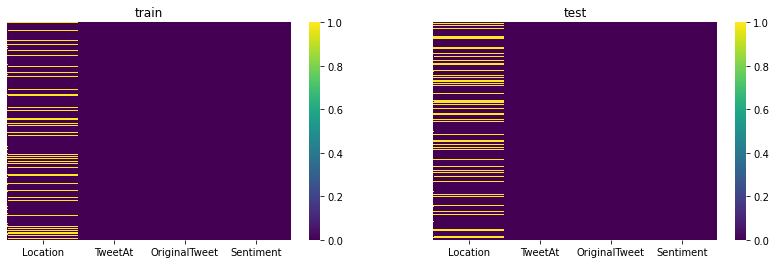

In [8]:
# show columns with missing values
plt.figure(figsize=(14,4))
for index, df in enumerate([train, test]):
    plt.subplot(1,2, index+1)
    sns.heatmap(df.isnull(), cmap='viridis', yticklabels= False).set_title('train' if index==0 else 'test')

plt.show()

In [9]:
# check number of missing values
print(train.isnull().sum())

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [10]:
# check Location
print(train.Location.value_counts(normalize= True, dropna= False)[:30] *100)

NaN                        20.871298
London                      1.312049
United States               1.282892
London, England             1.263455
New York, NY                0.959740
Washington, DC              0.906286
United Kingdom              0.818816
Los Angeles, CA             0.682751
India                       0.651165
UK                          0.563695
Australia                   0.546687
USA                         0.541828
Canada                      0.464077
England, United Kingdom     0.464077
Toronto, Ontario            0.388755
Global                      0.386326
Chicago, IL                 0.376607
California, USA             0.371747
San Francisco, CA           0.369317
Boston, MA                  0.364458
New York, USA               0.340161
New Delhi, India            0.335301
Atlanta, GA                 0.306145
New York                    0.306145
Mumbai, India               0.264840
Worldwide                   0.245402
Lagos, Nigeria              0.240542
A

- About 21% of the Location data is missing
- The Location values include both cities & countries and do not follow a consistent pattern - which makes it quite chaellnging to clean. However, I'll tidy up the column a bit by replacinig cases where we have for instance, `"London, England"` with just `"London"`; `"Los Angeles, CA"` with `"Los Angeles"`

In [11]:
train.Location = train.Location.str.split(',').str[0]

## Exploratory Data Analysis

### Sentiment

In [12]:
print(train.Sentiment.value_counts(normalize=True) * 100)

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64


To make analysis easier, let's rename the "Extremely Positive", "Extremely Negative" labels to "Positive" and "Negative" respectively

In [13]:
# replace "extremely positive/negative" with "postive/negative"
train["Sentiment"] = train["Sentiment"].str.replace("Extremely Negative", "Negative")
train["Sentiment"] = train["Sentiment"].str.replace("Extremely Positive", "Positive")

test['Sentiment'] = test.Sentiment.str.replace('Extremely Positive', 'Positive')
test['Sentiment'] = test.Sentiment.str.replace('Extremely Negative', 'Negative')

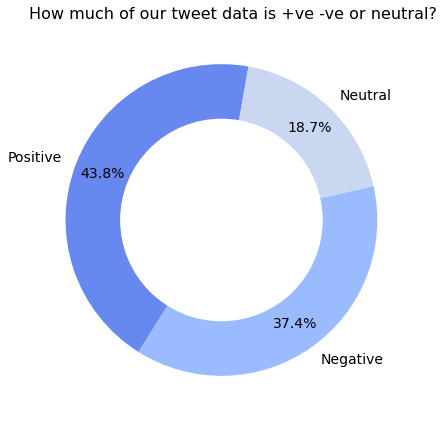

In [14]:
# plot of tweet sentiment distribution
plt.figure(figsize=(6,6))

sentiments = train.Sentiment.value_counts()

sns.set_palette("coolwarm")
plt.pie(sentiments,
        labels= sentiments.index,
        autopct='%1.1f%%', startangle=80, 
        pctdistance=0.82, textprops={"fontsize": 14})

centreCircle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)

plt.tight_layout()
plt.title("How much of our tweet data is +ve -ve or neutral?", x=0.53, fontsize= 16)

plt.show()

    - The tweets are mostly either postive or negative, with just about 20% of the tweet data classified as neutral

### Location
Let's check out the places around the world that tweeted the most about COVID. We'll also check out the mood of these tweets.

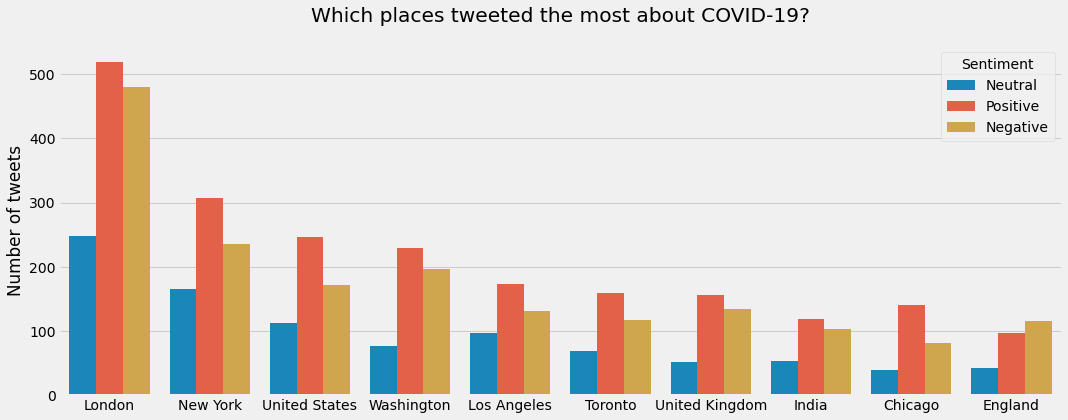

In [15]:
# plot of top cities/countries
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= train, hue="Sentiment", order=train.Location.value_counts()[:10].index)
location.set_title("Which places tweeted the most about COVID-19?", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Number of tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

    - Most covid-related tweets seem to come from four major countries - the United Kingdom, the USA, Cananda and India.
    - London and New York lead the way in terms of cities that tweeted the most about covid19
    - We also observe a pattern: there are more positive tweets than negative in all cities/countries, except England - well this actually follows the general trend in our data, as we have more postive tweets than negative and more negative ones than neutral

### Tweet At
As `TweetAt` contains dates the tweets in our data were made, let's proceed to find out:
- the period range our tweet data was gathered
- the most frequent day(s) of the week and month(s) users made covid-related tweets

For the latter, we would need to create a new day and month column

In [16]:
# Converting the TweetAt column to date time 
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

# create day of the week and month columns
train['day'] = train['TweetAt'].dt.dayofweek
train['month'] = train['TweetAt'].dt.month

days = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
months = {0: 'January ', 1: 'February', 2:'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July',
      7:'August', 8:'September', 9: 'October', 10: 'November', 11: 'December'  }

train["day"] = train["day"].map(days)
train["month"] = train["month"].map(months)

In [17]:
print(f"First tweet: {train['TweetAt'].dt.date.min()}, Last tweet: {train['TweetAt'].dt.date.max()}")

First tweet: 2020-01-04, Last tweet: 2020-12-04


    Our tweet data, which contains covid-related tweets made only in 2020, was collected over an 11-month period (January 4, 2020 through to December 4, 2020)

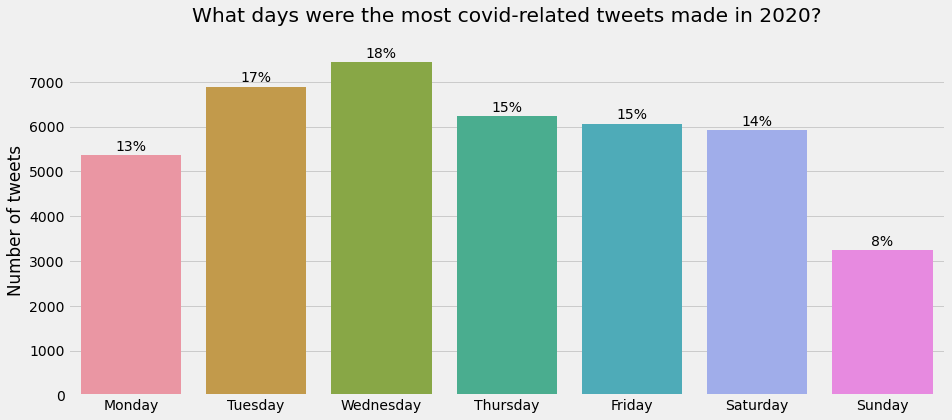

In [18]:
plt.figure(figsize=(14, 6))
days = sns.countplot(x="day", data=train)
days.set_title("What days were the most covid-related tweets made in 2020?", 
                                             y=1.05)

def add_labels(ax, space):
    for rect in ax.patches:
        width = rect.get_width()
        height = rect.get_height()
        total = train.shape[0]
        
        ax.text(rect.get_x() + width/2,
               height + space,
               '{}%'.format(int(np.round(height/total*100))),
                ha="center")

add_labels(days, 100)
axis_labels(days)
plt.show()

    - About 35% of the tweets were made on a Tuesday/Wednesday, with Sunday having the least engagement

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


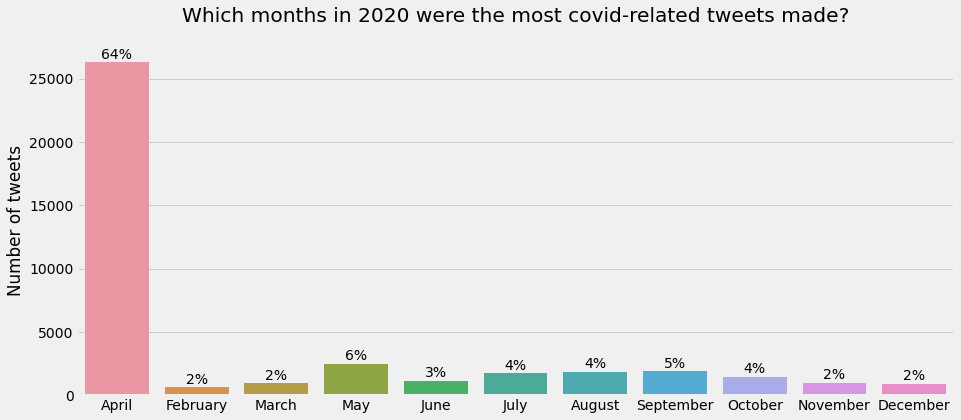

In [19]:
plt.figure(figsize=(14, 6))
months = sns.countplot(train['month'])
months.set_title("Which months in 2020 were the most covid-related tweets made?", 
                                             y=1.05)

add_labels(months, 300)
axis_labels(months)
plt.show()

- A whooping 64% of the tweets were made in April! 
- This could perhaps be because it was around this period the number of cases and death toll first skyrocketed.  
- According to the timeline of COVID-19 events stated in this [article](https://www.thinkglobalhealth.org/article/updated-timeline-coronavirus), the Week of March 30–April 4 saw the Worldwide coronavirus cases exceed one million; with millions of Americans filing for unemployment and major sporting events such Wimbledon Tennis Tournament getting canceled for the first time in a very long time. These were very serious and sudden events that shook the world and hence got people talking and tweeting a lot.

### Tweets

In [20]:
# check out the first two tweets
def tweets(df, n, col_name="OriginalTweet"):
    for tweet_no, tweet in enumerate(df[col_name][:n]):
        print(tweet_no+1, tweet, '\n')
        print("*" * 60, '\n')
        
tweets(train, 10)

1 @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 

************************************************************ 

2 advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 

************************************************************ 

3 Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P 

************************************************************ 






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j 

************************************************************ 





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n 

************************************

    The tweet data looks really unclean (well .. as expected) - but before proceeding to prepare our tweet text for modelling, let's explore the most frequent hashtags and top mentions in our data

#### Most common #hashtags

In [21]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

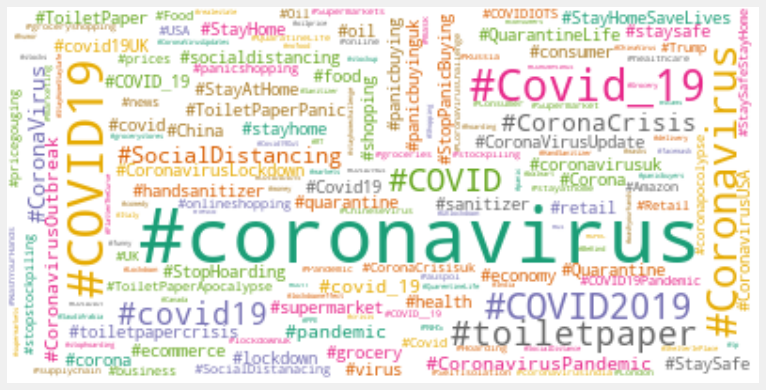

In [22]:
def create_wordCloud(pattern):
    """create word cloud visualization
    
    arguments:
        pattern (str): regex pattern to extract certain text from the data
    """
    data = train["OriginalTweet"].str.extractall(pattern)[0].value_counts()

    data.index = data.index.map(str)                                                       # convert data index to string
    data_wc = WordCloud(max_words = 500, colormap='Dark2_r', 
                        background_color='white').generate_from_frequencies(data)          # generate word cloud

    # display the cloud
    fig = plt.figure()
    fig.set_figwidth(12) # set width
    fig.set_figheight(12) # set height

    plt.imshow(data_wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# create word cloud of the most frequently used hashtags
hashtag = r"(#\w+)"
create_wordCloud(hashtag)

#### Most Mentions

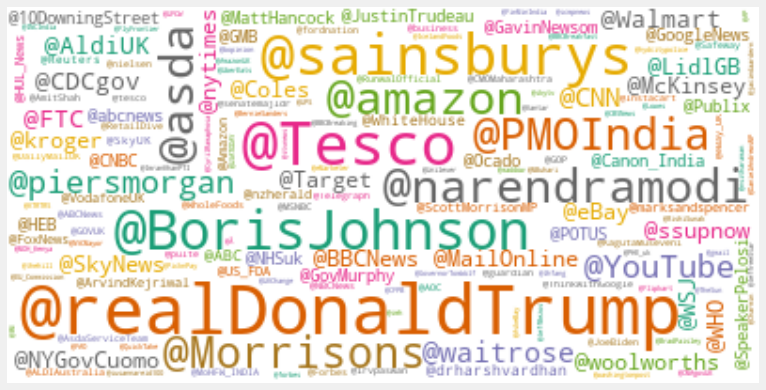

In [23]:
# create word cloud of most frequent mentions
mentions = r"(@\w+)"
create_wordCloud(mentions)

    - Former US president, Donald Trump is unsurprisingly among the most tagged persons. We also see the UK prime minister,   Boris Johnson and Indian Prime Minister, Narendra Modi also gathered a number of mentions
    - CNN, BBCNews and SkyNews are the most tagged news channels, with Piers Morgan being the most tagged TV personality 
    - Retail companies such as Tesco, Walmart and Morrisons got a lot of mentions too

## Text Preprocessing
Next step is to clean and prepare our tweet data for modeling. So,we proceed to:
- Remove all hastages, links and numbers
- Remove Stopwords (common words like "the", "a" etc)
- Tokenize and Vectorize words, i.e, convert tweet words to numbers

But first, we combine the training and test dataframes, then keep just the features relevant to our model building - `OriginalTweet` and `Sentiment`

In [24]:
# combine train and test dataframes
combined = pd.concat([train, test], ignore_index= True)

# select relevant features: tweet and Sentiments
combined = combined.loc[:, ["OriginalTweet", "Sentiment"]]

# load stop words
stop_word = stopwords.words('english')

def clean_tweet(text):
    text = re.sub(r"#\w+", " ", text)            # remove hashtags
    text = re.sub(r"@\w+", " ",text)             # remove mentions
    text = re.sub(r"http\S+", " ", text)         # remove urls
    text = re.sub(r"[^a-zA-Z]", " ", text)        # remove non-words (digits, punctuations etc)
    text = text.lower().strip()                  # convert tweet to lowercase and strip
    
    text = " ".join([word for word in text.split() if not word in stop_word])           # remove stop words    
    
    text = " ".join(nltk.word_tokenize(text))           # tokenize text
      
    return text

# clean OriginalTweet and assign the data to an new "tweet" column
combined['tweet'] = combined['OriginalTweet'].apply(lambda x: clean_tweet(x))

In [25]:
# print first few tweets to confirm the data is rid of non-word characters
tweets(combined, 7, "tweet")

1  

************************************************************ 

2 advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order 

************************************************************ 

3 coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak 

************************************************************ 

4 food stock one empty please panic enough food everyone take need stay calm stay safe 

************************************************************ 

5 ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage 

************************************************************ 

6 news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports 

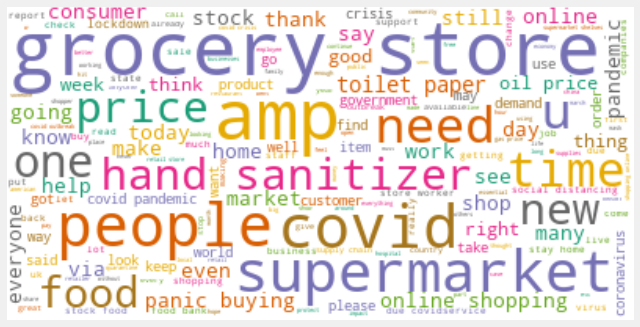

In [26]:
# most common words in our tweet data
corpus = ",".join(word for word in combined.tweet)
stopwords = set(STOPWORDS)
tweet_wc = WordCloud(max_words = 500, colormap='Dark2_r', 
                        background_color='white', stopwords=stopwords).generate(corpus)   

# display the cloud
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(tweet_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
# encode Sentiment label values
le = LabelEncoder()
combined.Sentiment = le.fit_transform(combined.Sentiment)

# split data back into training and validation sets and sets
train = combined[: len(train)]
test = combined[len(train):].reset_index(drop=True)

# split test test set
X_test = test.tweet
y_test = test.Sentiment


# split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train.tweet,
                                                    train.Sentiment, test_size=0.2,random_state=42)

In [28]:
# initialize vectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5).fit(X_train)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

## Modeling

### Logistic Regression

In [29]:
# intialize model and fit it on the training data
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, y_train)

# check training accuracy
cross_val_score(logmodel, X_train, y_train, cv=5, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


0.7938648443432041

In [30]:
# extract labels from encoder
labels = list(le.classes_)

In [31]:
# make predictions
val_pred = logmodel.predict(X_val)
test_pred = logmodel.predict(X_test)

# print classification report
print(classification_report(val_pred, y_val, target_names= labels), '\n')
print(classification_report(test_pred, y_test, target_names= labels))

              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80      2949
     Neutral       0.75      0.70      0.72      1677
    Positive       0.84      0.84      0.84      3606

    accuracy                           0.80      8232
   macro avg       0.79      0.78      0.79      8232
weighted avg       0.80      0.80      0.80      8232
 

              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80      1542
     Neutral       0.69      0.66      0.68       648
    Positive       0.83      0.80      0.82      1608

    accuracy                           0.79      3798
   macro avg       0.77      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798



In [32]:
# check test accuracy
print('accuracy score on validation set: ', accuracy_score(y_val, val_pred))
print('accuracy score on test set:', accuracy_score(y_test, test_pred))

accuracy score on validation set:  0.8029640427599611
accuracy score on test set: 0.7859399684044234


    The model performs about the same on both the validation set and the given test dataset
    
Next, we check out how the LSTM model will perform on our data

### LSTM

In [33]:
max_features = 20000                                            # maximum number of words to take from corpus
tokenizer = Tokenizer(num_words=max_features, split=' ')            # initialize tokenizer
tokenizer.fit_on_texts(train['tweet'].values)                   # fit tokenizer on training data


max_len = np.max(train.tweet.apply(lambda x :len(x)))
vocab_length = len(tokenizer.word_index)

In [34]:
print("Number of unique token:", vocab_length)
print("Maximum sequence length:", max_len)

Number of unique token: 32222
Maximum sequence length: 266


In [35]:
# get text sequences from training and test dataframes
train_x = tokenizer.texts_to_sequences(train['tweet'].values)
X_test = tokenizer.texts_to_sequences(test['tweet'].values)


# adding padding of zeros to obtain uniform length for all sequences
train_x = pad_sequences(train_x, maxlen= max_len)
X_test = pad_sequences(X_test, maxlen= max_len)

# encode sentiment label values
train_y_encoded = pd.get_dummies(train['Sentiment']).values
y_test_encoded = pd.get_dummies(test['Sentiment']).values


# split training data 
X_train, X_val, Y_train, y_val = train_test_split(train_x, train_y_encoded, test_size = 0.33, random_state = 42)

In [36]:
print(train_x.shape, X_test.shape)
print(train_y_encoded.shape, y_test_encoded.shape)

(41157, 266) (3798, 266)
(41157, 3) (3798, 3)


In [37]:
print(X_train.shape,Y_train.shape)
print(X_val.shape, y_val.shape)

(27575, 266) (27575, 3)
(13582, 266) (13582, 3)


#### Model Building

In [38]:
embed_dim = 16
lstm_out = 196

model = Sequential()
model.add(Embedding(vocab_length, embed_dim, input_length = max_len))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam',
              metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 266, 16)           515552    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 266, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               166992    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 683,135
Trainable params: 683,135
Non-trainable params: 0
_________________________________________________________________
None


#### Model Training

In [39]:
model.fit(X_train, Y_train, 
          validation_data=(X_val, y_val), 
          epochs=5, batch_size= 32, 
          shuffle=True)

Epoch 1/5
862/862 [==============================] - 747s 863ms/step - loss: 0.9448 - accuracy: 0.5042 - val_loss: 0.6215 - val_accuracy: 0.7522
Epoch 2/5
862/862 [==============================] - 752s 872ms/step - loss: 0.5297 - accuracy: 0.7997 - val_loss: 0.4617 - val_accuracy: 0.8323
Epoch 3/5
862/862 [==============================] - 761s 882ms/step - loss: 0.3773 - accuracy: 0.8693 - val_loss: 0.4279 - val_accuracy: 0.8504
Epoch 4/5
862/862 [==============================] - 763s 885ms/step - loss: 0.3095 - accuracy: 0.8942 - val_loss: 0.4383 - val_accuracy: 0.8535
Epoch 5/5
862/862 [==============================] - 764s 886ms/step - loss: 0.2592 - accuracy: 0.9150 - val_loss: 0.4428 - val_accuracy: 0.8503


#### Model Evaluation

In [40]:
# evaluating model on test dataset
model.evaluate(X_test, y_test_encoded, verbose=0)

[0.5048713684082031, 0.8343865275382996]

In [41]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# predictions = model.predict_classes(X_test)

In [42]:
# classification report
print(classification_report(y_test, predictions, target_names= labels))

              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      1633
     Neutral       0.85      0.73      0.78       619
    Positive       0.81      0.89      0.85      1546

    accuracy                           0.83      3798
   macro avg       0.84      0.81      0.82      3798
weighted avg       0.84      0.83      0.83      3798



    - As seen, the LTSM algorithm yields a better performance on our data (84% accuracy) than the Logistic Regression (79% accuracy)
    - While 79-84% is a fairly good score for accuracy, the performance of each model can still be further improved by tuning necessary parameters

##### Author: Ayomide Aderonmu